In [1]:
from pathlib import Path
import os
import pandas as pd
import sys
import requests
from functools import partial

import torch
import torchvision
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch 
from einops import rearrange, repeat
from loguru import logger
from torchmetrics import Metric, BootStrapper
import matplotlib.pyplot as plt
from PIL import Image
import pickle
import seaborn as sns
from matplotlib.pyplot import figure
from cka import gram, centering_mat, centered_gram, unbiased_hsic_xy, MinibatchCKA, HookedCache, make_pairwise_metrics, update_metrics, get_simmat_from_metrics
import numpy as np
import re

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import timm
from torch.utils.tensorboard import SummaryWriter

sys.path.append('..')
sys.path.append('../dino')
sys.path.append('../moco-v3')
import models_mae

import moco.builder
import moco.loader
import moco.optimizer

import vits

writer = SummaryWriter()

DEVICE = torch.device('cpu')
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')

In [2]:
from torch.nn.modules.container import Sequential
from torchvision.models.resnet import Bottleneck
from torchvision.models.vision_transformer import EncoderBlock
from timm.models.vision_transformer import Block

In [3]:
# using the validation transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            normalize,
        ])

## Randomly subsample features too

data_path='/datasets01/imagenet_full_size/061417/'
dataset = torchvision.datasets.ImageFolder(data_path + 'val', transform=transform)

In [4]:
indexes = np.random.uniform(low=0, high=len(dataset), size=1024).astype(int)
subset = torch.utils.data.Subset(dataset, indexes)

data_loader = torch.utils.data.DataLoader(subset,
                                        batch_size=32,
                                        shuffle=False,
                                        pin_memory=False)

log_every = 10
do_log = True

# Get models

In [5]:
vitb16_dino = torch.hub.load('facebookresearch/dino:main', 'dino_vitb16')

Using cache found in /private/home/sshkhr/.cache/torch/hub/facebookresearch_dino_main


In [6]:
def prepare_model(chkpt_dir, arch='mae_vit_base_patch16'):
    # build model
    model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

In [7]:
#!wget https://dl.fbaipublicfiles.com/mae/pretrain/mae_pretrain_vit_base.pth

chkpt_dir = '../checkpoints/pretrained/mae_pretrain_vit_base.pth'
vitb16_mae = prepare_model(chkpt_dir, 'mae_vit_base_patch16')
print('Model loaded.')

_IncompatibleKeys(missing_keys=['mask_token', 'decoder_pos_embed', 'decoder_embed.weight', 'decoder_embed.bias', 'decoder_blocks.0.norm1.weight', 'decoder_blocks.0.norm1.bias', 'decoder_blocks.0.attn.qkv.weight', 'decoder_blocks.0.attn.qkv.bias', 'decoder_blocks.0.attn.proj.weight', 'decoder_blocks.0.attn.proj.bias', 'decoder_blocks.0.norm2.weight', 'decoder_blocks.0.norm2.bias', 'decoder_blocks.0.mlp.fc1.weight', 'decoder_blocks.0.mlp.fc1.bias', 'decoder_blocks.0.mlp.fc2.weight', 'decoder_blocks.0.mlp.fc2.bias', 'decoder_blocks.1.norm1.weight', 'decoder_blocks.1.norm1.bias', 'decoder_blocks.1.attn.qkv.weight', 'decoder_blocks.1.attn.qkv.bias', 'decoder_blocks.1.attn.proj.weight', 'decoder_blocks.1.attn.proj.bias', 'decoder_blocks.1.norm2.weight', 'decoder_blocks.1.norm2.bias', 'decoder_blocks.1.mlp.fc1.weight', 'decoder_blocks.1.mlp.fc1.bias', 'decoder_blocks.1.mlp.fc2.weight', 'decoder_blocks.1.mlp.fc2.bias', 'decoder_blocks.2.norm1.weight', 'decoder_blocks.2.norm1.bias', 'decoder_bl

In [8]:
vitb16_mocov3 = vits.vit_base(stop_grad_conv1=True)
checkpoint = torch.load('../checkpoints/pretrained/mocov3-vit-b-300ep.pth.tar', map_location='cpu')
state_dict = checkpoint['state_dict']
for k in list(state_dict.keys()):
    # retain only base_encoder up to before the embedding layer
    if k.startswith('module.base_encoder') and not k.startswith('module.base_encoder.%s' % 'head'):
        # remove prefix
        state_dict[k[len("module.base_encoder."):]] = state_dict[k]
    # delete renamed or unused k
    del state_dict[k]
msg = vitb16_mocov3.load_state_dict(state_dict, strict=False)

/private/home/sshkhr/.conda/envs/pytorch_env/lib/python3.9/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646756402876/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [9]:
vitb16_supervised = torchvision.models.vit_b_16(pretrained=True)

In [11]:
resnet50_mocov3 = torchvision.models.resnet50(pretrained=False)
checkpoint = torch.load('../checkpoints/pretrained/mocov3-resnet-50-300ep.pth.tar', map_location='cpu')
state_dict = checkpoint['state_dict']
for k in list(state_dict.keys()):
    # retain only base_encoder up to before the embedding layer
    if k.startswith('module.base_encoder') and not k.startswith('module.base_encoder.%s' % 'head'):
        # remove prefix
        state_dict[k[len("module.base_encoder."):]] = state_dict[k]
    # delete renamed or unused k
    del state_dict[k]
msg = resnet50_mocov3.load_state_dict(state_dict, strict=False)

In [12]:
resnet50_dino = torch.hub.load('facebookresearch/dino:main', 'dino_resnet50')

Using cache found in /private/home/sshkhr/.cache/torch/hub/facebookresearch_dino_main


In [13]:
for name, module in vitb16_mocov3.named_modules():
        print(name, type(module))

 <class 'vits.VisionTransformerMoCo'>
patch_embed <class 'timm.models.layers.patch_embed.PatchEmbed'>
patch_embed.proj <class 'torch.nn.modules.conv.Conv2d'>
patch_embed.norm <class 'torch.nn.modules.linear.Identity'>
pos_drop <class 'torch.nn.modules.dropout.Dropout'>
blocks <class 'torch.nn.modules.container.Sequential'>
blocks.0 <class 'timm.models.vision_transformer.Block'>
blocks.0.norm1 <class 'torch.nn.modules.normalization.LayerNorm'>
blocks.0.attn <class 'timm.models.vision_transformer.Attention'>
blocks.0.attn.qkv <class 'torch.nn.modules.linear.Linear'>
blocks.0.attn.attn_drop <class 'torch.nn.modules.dropout.Dropout'>
blocks.0.attn.proj <class 'torch.nn.modules.linear.Linear'>
blocks.0.attn.proj_drop <class 'torch.nn.modules.dropout.Dropout'>
blocks.0.drop_path <class 'torch.nn.modules.linear.Identity'>
blocks.0.norm2 <class 'torch.nn.modules.normalization.LayerNorm'>
blocks.0.mlp <class 'timm.models.layers.mlp.Mlp'>
blocks.0.mlp.fc1 <class 'torch.nn.modules.linear.Linear'>

In [14]:
for name, module in vitb16_dino.named_modules():
        print(name, type(module))

 <class 'vision_transformer.VisionTransformer'>
patch_embed <class 'vision_transformer.PatchEmbed'>
patch_embed.proj <class 'torch.nn.modules.conv.Conv2d'>
pos_drop <class 'torch.nn.modules.dropout.Dropout'>
blocks <class 'torch.nn.modules.container.ModuleList'>
blocks.0 <class 'vision_transformer.Block'>
blocks.0.norm1 <class 'torch.nn.modules.normalization.LayerNorm'>
blocks.0.attn <class 'vision_transformer.Attention'>
blocks.0.attn.qkv <class 'torch.nn.modules.linear.Linear'>
blocks.0.attn.attn_drop <class 'torch.nn.modules.dropout.Dropout'>
blocks.0.attn.proj <class 'torch.nn.modules.linear.Linear'>
blocks.0.attn.proj_drop <class 'torch.nn.modules.dropout.Dropout'>
blocks.0.drop_path <class 'torch.nn.modules.linear.Identity'>
blocks.0.norm2 <class 'torch.nn.modules.normalization.LayerNorm'>
blocks.0.mlp <class 'vision_transformer.Mlp'>
blocks.0.mlp.fc1 <class 'torch.nn.modules.linear.Linear'>
blocks.0.mlp.act <class 'torch.nn.modules.activation.GELU'>
blocks.0.mlp.fc2 <class 'torc

In [15]:
for name, module in vitb16_mae.named_modules():
        print(name, type(module))

 <class 'models_mae.MaskedAutoencoderViT'>
patch_embed <class 'timm.models.layers.patch_embed.PatchEmbed'>
patch_embed.proj <class 'torch.nn.modules.conv.Conv2d'>
patch_embed.norm <class 'torch.nn.modules.linear.Identity'>
blocks <class 'torch.nn.modules.container.ModuleList'>
blocks.0 <class 'timm.models.vision_transformer.Block'>
blocks.0.norm1 <class 'torch.nn.modules.normalization.LayerNorm'>
blocks.0.attn <class 'timm.models.vision_transformer.Attention'>
blocks.0.attn.qkv <class 'torch.nn.modules.linear.Linear'>
blocks.0.attn.attn_drop <class 'torch.nn.modules.dropout.Dropout'>
blocks.0.attn.proj <class 'torch.nn.modules.linear.Linear'>
blocks.0.attn.proj_drop <class 'torch.nn.modules.dropout.Dropout'>
blocks.0.drop_path <class 'torch.nn.modules.linear.Identity'>
blocks.0.norm2 <class 'torch.nn.modules.normalization.LayerNorm'>
blocks.0.mlp <class 'timm.models.layers.mlp.Mlp'>
blocks.0.mlp.fc1 <class 'torch.nn.modules.linear.Linear'>
blocks.0.mlp.act <class 'torch.nn.modules.acti

In [16]:
for name, module in resnet50_mocov3.named_modules():
        print(name, type(module))

 <class 'torchvision.models.resnet.ResNet'>
conv1 <class 'torch.nn.modules.conv.Conv2d'>
bn1 <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
relu <class 'torch.nn.modules.activation.ReLU'>
maxpool <class 'torch.nn.modules.pooling.MaxPool2d'>
layer1 <class 'torch.nn.modules.container.Sequential'>
layer1.0 <class 'torchvision.models.resnet.Bottleneck'>
layer1.0.conv1 <class 'torch.nn.modules.conv.Conv2d'>
layer1.0.bn1 <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
layer1.0.conv2 <class 'torch.nn.modules.conv.Conv2d'>
layer1.0.bn2 <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
layer1.0.conv3 <class 'torch.nn.modules.conv.Conv2d'>
layer1.0.bn3 <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
layer1.0.relu <class 'torch.nn.modules.activation.ReLU'>
layer1.0.downsample <class 'torch.nn.modules.container.Sequential'>
layer1.0.downsample.0 <class 'torch.nn.modules.conv.Conv2d'>
layer1.0.downsample.1 <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
layer1.1 <class 'torchvision.models.resne

In [17]:
for name, module in resnet50_dino.named_modules():
        print(name, type(module))

 <class 'torchvision.models.resnet.ResNet'>
conv1 <class 'torch.nn.modules.conv.Conv2d'>
bn1 <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
relu <class 'torch.nn.modules.activation.ReLU'>
maxpool <class 'torch.nn.modules.pooling.MaxPool2d'>
layer1 <class 'torch.nn.modules.container.Sequential'>
layer1.0 <class 'torchvision.models.resnet.Bottleneck'>
layer1.0.conv1 <class 'torch.nn.modules.conv.Conv2d'>
layer1.0.bn1 <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
layer1.0.conv2 <class 'torch.nn.modules.conv.Conv2d'>
layer1.0.bn2 <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
layer1.0.conv3 <class 'torch.nn.modules.conv.Conv2d'>
layer1.0.bn3 <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
layer1.0.relu <class 'torch.nn.modules.activation.ReLU'>
layer1.0.downsample <class 'torch.nn.modules.container.Sequential'>
layer1.0.downsample.0 <class 'torch.nn.modules.conv.Conv2d'>
layer1.0.downsample.1 <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
layer1.1 <class 'torchvision.models.resne

In [18]:
vitb16_dino.to(DEVICE)
vitb16_mae.to(DEVICE)
vitb16_mocov3.to(DEVICE)
vitb16_supervised.to(DEVICE)
resnet50_dino.to(DEVICE)
resnet50_mocov3.to(DEVICE)

#vitb16_dino = torch.nn.DataParallel(vitb16_dino)
#vitb16_mae = torch.nn.DataParallel(vitb16_mae)
#vitb16_mocov3 = torch.nn.DataParallel(vitb16_mocov3)

vitb16_dino.eval()
vitb16_mae.eval()
vitb16_mocov3.eval()
vitb16_supervised.eval()
resnet50_dino.eval()
resnet50_mocov3.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [19]:
from timm.models.vision_transformer import Block as timm_block
from vision_transformer import Block

In [20]:
#%%time

log_every = 10

modc_hooks = []
for name, module in vitb16_dino.named_modules():
  if ('drop' not in name and 'out_proj' and 'block' in name and 'head' not in name and name != 'blocks' and not isinstance(module, Block)):
    print(name, type(module))
    tgt = name
    hook = HookedCache(vitb16_dino, tgt)
    modc_hooks.append(hook)

modt_hooks = []
for name, module in vitb16_mae.named_modules():
  if ('drop' not in name and 'decoder' not in name and 'block' in name and 'head' not in name and name != 'blocks' and not isinstance(module, timm_block)):
    print(name, type(module))
    tgt = name
    hook = HookedCache(vitb16_mae, tgt)
    modt_hooks.append(hook)

modmv_hooks = []
for name, module in vitb16_mocov3.named_modules():
  if ('drop' not in name and 'decoder' not in name and 'momentum_encoder' not in name and 'block' in name and 'head' not in name and name != 'blocks' and not isinstance(module, timm_block)):
    print(name, type(module))
    tgt = name
    hook = HookedCache(vitb16_mocov3, tgt)
    modmv_hooks.append(hook)

'''
mods_hooks = []
for name, module in vitb16_supervised.named_modules():
  if ('drop' not in name and 'conv' not in name and 'encoder' in name and 'head' not in name and name != 'encoder' and name != 'encoder.ln' and not isinstance(module, Sequential)):
    print(name, type(module))
    tgt = name
    hook = HookedCache(vitb16_supervised, tgt)
    mods_hooks.append(hook)
'''


blocks.0.norm1 <class 'torch.nn.modules.normalization.LayerNorm'>
blocks.0.attn <class 'vision_transformer.Attention'>
blocks.0.attn.qkv <class 'torch.nn.modules.linear.Linear'>
blocks.0.attn.proj <class 'torch.nn.modules.linear.Linear'>
blocks.0.norm2 <class 'torch.nn.modules.normalization.LayerNorm'>
blocks.0.mlp <class 'vision_transformer.Mlp'>
blocks.0.mlp.fc1 <class 'torch.nn.modules.linear.Linear'>
blocks.0.mlp.act <class 'torch.nn.modules.activation.GELU'>
blocks.0.mlp.fc2 <class 'torch.nn.modules.linear.Linear'>
blocks.1.norm1 <class 'torch.nn.modules.normalization.LayerNorm'>
blocks.1.attn <class 'vision_transformer.Attention'>
blocks.1.attn.qkv <class 'torch.nn.modules.linear.Linear'>
blocks.1.attn.proj <class 'torch.nn.modules.linear.Linear'>
blocks.1.norm2 <class 'torch.nn.modules.normalization.LayerNorm'>
blocks.1.mlp <class 'vision_transformer.Mlp'>
blocks.1.mlp.fc1 <class 'torch.nn.modules.linear.Linear'>
blocks.1.mlp.act <class 'torch.nn.modules.activation.GELU'>
blocks

"\nmods_hooks = []\nfor name, module in vitb16_supervised.named_modules():\n  if ('drop' not in name and 'conv' not in name and 'encoder' in name and 'head' not in name and name != 'encoder' and name != 'encoder.ln' and not isinstance(module, Sequential)):\n    print(name, type(module))\n    tgt = name\n    hook = HookedCache(vitb16_supervised, tgt)\n    mods_hooks.append(hook)\n"

In [21]:
from torch.nn.modules.container import Sequential
from torchvision.models.resnet import Bottleneck

In [22]:
modrd_hooks = []
for name, module in resnet50_dino.named_modules():
  if 'drop' not in name and name != '' and name != '' and name != 'fc' and name != 'avgpool' and not isinstance(module, Sequential) and not isinstance(module, Bottleneck):
    print(name, type(module))
    tgt = name
    hook = HookedCache(resnet50_dino, tgt)
    modrd_hooks.append(hook)


modrc_hooks = []
for name, module in resnet50_mocov3.named_modules():
  if 'drop' not in name and name != '' and name != '' and name != 'fc' and name != 'avgpool' and not isinstance(module, Sequential) and not isinstance(module, Bottleneck):
    print(name, type(module))
    tgt = name
    hook = HookedCache(resnet50_mocov3, tgt)
    modrc_hooks.append(hook)

conv1 <class 'torch.nn.modules.conv.Conv2d'>
bn1 <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
relu <class 'torch.nn.modules.activation.ReLU'>
maxpool <class 'torch.nn.modules.pooling.MaxPool2d'>
layer1.0.conv1 <class 'torch.nn.modules.conv.Conv2d'>
layer1.0.bn1 <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
layer1.0.conv2 <class 'torch.nn.modules.conv.Conv2d'>
layer1.0.bn2 <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
layer1.0.conv3 <class 'torch.nn.modules.conv.Conv2d'>
layer1.0.bn3 <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
layer1.0.relu <class 'torch.nn.modules.activation.ReLU'>
layer1.0.downsample.0 <class 'torch.nn.modules.conv.Conv2d'>
layer1.0.downsample.1 <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
layer1.1.conv1 <class 'torch.nn.modules.conv.Conv2d'>
layer1.1.bn1 <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
layer1.1.conv2 <class 'torch.nn.modules.conv.Conv2d'>
layer1.1.bn2 <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
layer1.1.conv3 <class 'torch.nn.

In [ ]:
#metrics_ct = make_pairwise_metrics(modc_hooks, modt_hooks, device=DEVICE)
#metrics_cc = make_pairwise_metrics(modc_hooks, modc_hooks, device=DEVICE)
#metrics_tt = make_pairwise_metrics(modt_hooks, modt_hooks, device=DEVICE)
#metrics_mvmv = make_pairwise_metrics(modmv_hooks, modmv_hooks, device=DEVICE)
#metrics_tmv = make_pairwise_metrics(modt_hooks, modmv_hooks, device=DEVICE)
#metrics_cmv = make_pairwise_metrics(modc_hooks, modmv_hooks, device=DEVICE)
#metrics_st = make_pairwise_metrics(mods_hooks, modt_hooks, device=DEVICE)
#metrics_sc = make_pairwise_metrics(mods_hooks, modc_hooks, device=DEVICE)
#metrics_smv = make_pairwise_metrics(mods_hooks, modmv_hooks, device=DEVICE)

metrics_crc = make_pairwise_metrics(modc_hooks, modrc_hooks, device=DEVICE)
metrics_crd = make_pairwise_metrics(modc_hooks, modrd_hooks, device=DEVICE)
metrics_trc = make_pairwise_metrics(modt_hooks, modrc_hooks, device=DEVICE)
metrics_trd = make_pairwise_metrics(modt_hooks, modrd_hooks, device=DEVICE)
metrics_mvrc = make_pairwise_metrics(modmv_hooks, modrc_hooks, device=DEVICE)
metrics_mvrd = make_pairwise_metrics(modmv_hooks, modrd_hooks, device=DEVICE)
metrics_rcrc = make_pairwise_metrics(modrc_hooks, modrc_hooks, device=DEVICE)
metrics_rcrd = make_pairwise_metrics(modrc_hooks, modrd_hooks, device=DEVICE)
metrics_rdrd = make_pairwise_metrics(modrd_hooks, modrd_hooks, device=DEVICE)

In [ ]:
with torch.no_grad():
  
  for it, [batch, label] in enumerate(data_loader):
    batch = batch.to(DEVICE)
    do_log =  (it % log_every == 0)
    if do_log:
      logger.debug(f"iter: {it}")
    outv_c = vitb16_dino(batch)
    outv_t = vitb16_mae(batch)
    outv_mv = vitb16_mocov3(batch)
    outv_s = vitb16_supervised(batch)
    
    
    #update_metrics(modc_hooks, modt_hooks, metrics_ct, "cka/ct", do_log,  device=DEVICE)
    #update_metrics(modc_hooks, modc_hooks, metrics_cc, "cka/cc", do_log,  device=DEVICE)
    #update_metrics(modt_hooks, modt_hooks, metrics_tt, "cka/tt", do_log,  device=DEVICE)
    #update_metrics(modmv_hooks, modmv_hooks, metrics_mvmv, "cka/mvmv", do_log,  device=DEVICE)
    #update_metrics(modt_hooks, modmv_hooks, metrics_tmv, "cka/tmv", do_log,  device=DEVICE)
    #update_metrics(modc_hooks, modmv_hooks, metrics_cmv, "cka/cmv", do_log,  device=DEVICE)
    #update_metrics(mods_hooks, modc_hooks, metrics_sc, "cka/sc", do_log,  device=DEVICE)
    #update_metrics(mods_hooks, modt_hooks, metrics_st, "cka/st", do_log,  device=DEVICE)
    #update_metrics(mods_hooks, modmv_hooks, metrics_smv, "cka/smv", do_log,  device=DEVICE)
        
    for hook0 in modc_hooks:
      for hook1 in modt_hooks:
        for hook2 in modmv_hooks:
          for hook3 in modrc_hooks:
            for hook4 in modrd_hooks:
              hook0.clear()
              hook1.clear()
              hook2.clear()
              hook3.clear()
              hook4.clear()

In [ ]:
'''
sim_mat_cc = get_simmat_from_metrics(metrics_cc)
sim_mat_ct = get_simmat_from_metrics(metrics_ct)
sim_mat_tt = get_simmat_from_metrics(metrics_tt)
sim_mat_cmv = get_simmat_from_metrics(metrics_cmv)
sim_mat_tmv = get_simmat_from_metrics(metrics_tmv)
sim_mat_mvmv = get_simmat_from_metrics(metrics_mvmv)
sim_mat_sc = get_simmat_from_metrics(metrics_sc)
sim_mat_st = get_simmat_from_metrics(metrics_st)
sim_mat_smv = get_simmat_from_metrics(metrics_smv)
'''

sim_mat_crc = get_simmat_from_metrics(metrics_crc)
sim_mat_crd = get_simmat_from_metrics(metrics_crd)
sim_mat_trc = get_simmat_from_metrics(metrics_trc)
sim_mat_trd = get_simmat_from_metrics(metrics_trd)
sim_mat_mvrc = get_simmat_from_metrics(metrics_mvrc)
sim_mat_mvrd = get_simmat_from_metrics(metrics_mvrd)
sim_mat_rcrd = get_simmat_from_metrics(metrics_rcrd)
sim_mat_rcrc = get_simmat_from_metrics(metrics_rcrc)
sim_mat_rdrd = get_simmat_from_metrics(metrics_rdrd)

In [ ]:
folder = "../sim_mat/"

'''
with open('sim_mat_DINO.pkl', 'wb') as f:
    pickle.dump(sim_mat_cc, f)

with open('sim_mat_DINO-MAE.pkl', 'wb') as f:
    pickle.dump(sim_mat_ct, f)

with open('sim_mat_MAE.pkl', 'wb') as f:
    pickle.dump(sim_mat_tt, f)

with open('sim_mat_MOCOv3.pkl', 'wb') as f:
    pickle.dump(sim_mat_mvmv, f)

with open('sim_mat_MAE-MOCOv3.pkl', 'wb') as f:
    pickle.dump(sim_mat_cmv, f)

with open('sim_mat_DINO-MOCOv3.pkl', 'wb') as f:
    pickle.dump(sim_mat_tmv, f)

with open('sim_mat_Supervised-DINO.pkl', 'wb') as f:
    pickle.dump(sim_mat_sc, f)

with open('sim_mat_Supervised-MAE.pkl', 'wb') as f:
    pickle.dump(sim_mat_st, f)

with open('sim_mat_Supervised-MOCOv3.pkl', 'wb') as f:
    pickle.dump(sim_mat_smv, f)
'''

with open(folder + 'sim_mat_DINO-ResNet50.pkl', 'wb') as f:
    pickle.dump(sim_mat_rdrd, f)

with open(folder + 'sim_mat_DINO-MOCOv3-ResNet50.pkl', 'wb') as f:
    pickle.dump(sim_mat_rcrd, f)

with open(folder + 'sim_mat_MOCOv3-ResNet50.pkl', 'wb') as f:
    pickle.dump(sim_mat_rcrc, f)

with open(folder + 'sim_mat_DINO-ViT-DINO-ResNet50.pkl', 'wb') as f:
    pickle.dump(sim_mat_crd, f)

with open(folder + 'sim_mat_DINO-ViT-MOCOv3-ResNet50.pkl', 'wb') as f:
    pickle.dump(sim_mat_crc, f)

with open(folder + 'sim_mat_MOCOv3-ViT-DINO-ResNet50.pkl', 'wb') as f:
    pickle.dump(sim_mat_mvrd, f)

with open(folder + 'sim_mat_MOCOv3-ViT-MOCOv3-ResNet50.pkl', 'wb') as f:
    pickle.dump(sim_mat_mvrc, f)

with open(folder + 'sim_mat_MAE-ViT-DINO-ResNet50.pkl', 'wb') as f:
    pickle.dump(sim_mat_trd, f)

with open(folder + 'sim_mat_MAE-ViT-MOCOv3-ResNet50.pkl', 'wb') as f:
    pickle.dump(sim_mat_trc, f)


In [2]:
folder = "../sim_mat/"

In [3]:
with open(folder + 'sim_mat_MAE.pkl', 'rb') as f:
    sim_mat_tt = pickle.load(f)

with open(folder + 'sim_mat_DINO-MAE.pkl', 'rb') as f:
    sim_mat_ct = pickle.load(f)

with open(folder + 'sim_mat_DINO.pkl', 'rb') as f:
    sim_mat_cc = pickle.load(f)

with open(folder + 'sim_mat_MOCOv3.pkl', 'rb') as f:
    sim_mat_mvmv = pickle.load(f)

with open(folder + 'sim_mat_MAE-MOCOv3.pkl', 'rb') as f:
    sim_mat_cmv = pickle.load(f)

with open(folder + 'sim_mat_DINO-MOCOv3.pkl', 'rb') as f:
    sim_mat_tmv = pickle.load(f)

with open(folder + 'sim_mat_Supervised-DINO.pkl', 'rb') as f:
    sim_mat_sc = pickle.load(f)

with open(folder + 'sim_mat_Supervised-MAE.pkl', 'rb') as f:
    sim_mat_st = pickle.load(f)

with open(folder + 'sim_mat_Supervised-MOCOv3.pkl', 'rb') as f:
    sim_mat_smv = pickle.load(f)

with open(folder + 'sim_mat_DINO-ResNet50.pkl', 'rb') as f:
    sim_mat_rdrd = pickle.load(f)

with open(folder + 'sim_mat_DINO-MOCOv3-ResNet50.pkl', 'rb') as f:
    sim_mat_rcrd = pickle.load(f)
    
with open(folder + 'sim_mat_MOCOv3-ResNet50.pkl', 'rb') as f:
    sim_mat_rcrc = pickle.load(f)
    
with open(folder + 'sim_mat_DINO-ViT-DINO-ResNet50.pkl', 'rb') as f:
    sim_mat_crd = pickle.load(f)
    
with open(folder + 'sim_mat_DINO-ViT-MOCOv3-ResNet50.pkl', 'rb') as f:
    sim_mat_crc = pickle.load(f)
    
with open(folder + 'sim_mat_MOCOv3-ViT-DINO-ResNet50.pkl', 'rb') as f:
    sim_mat_mvrd = pickle.load(f)
    
with open(folder + 'sim_mat_MOCOv3-ViT-MOCOv3-ResNet50.pkl', 'rb') as f:
    sim_mat_mvrc = pickle.load(f)
    
with open(folder + 'sim_mat_MAE-ViT-DINO-ResNet50.pkl', 'rb') as f:
    sim_mat_trd = pickle.load(f)
    
with open(folder + 'sim_mat_MAE-ViT-MOCOv3-ResNet50.pkl', 'rb') as f:
    sim_mat_trc = pickle.load(f)

In [4]:
from matplotlib.pyplot import figure

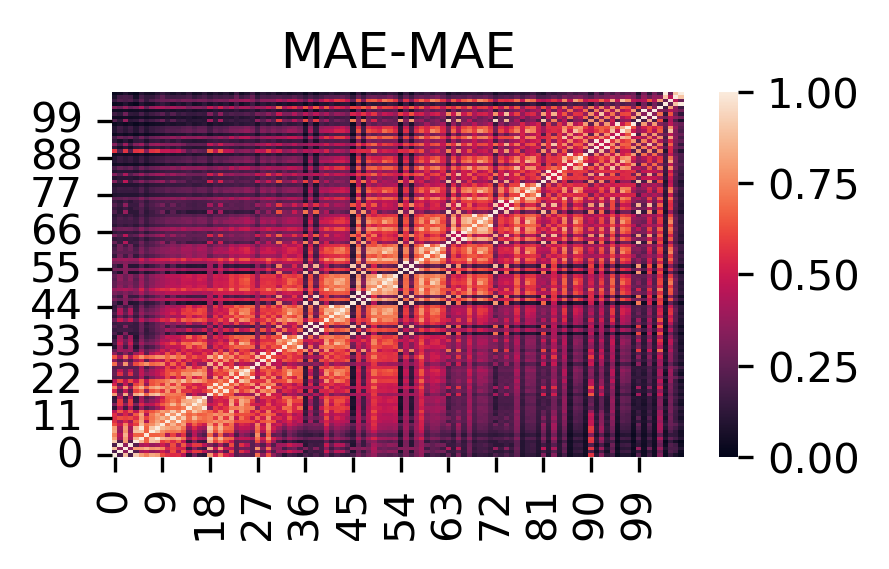

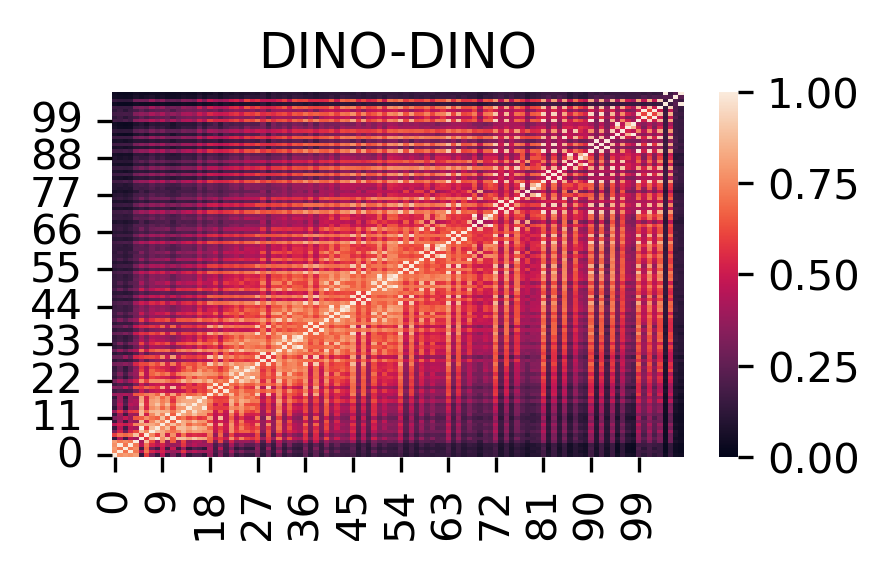

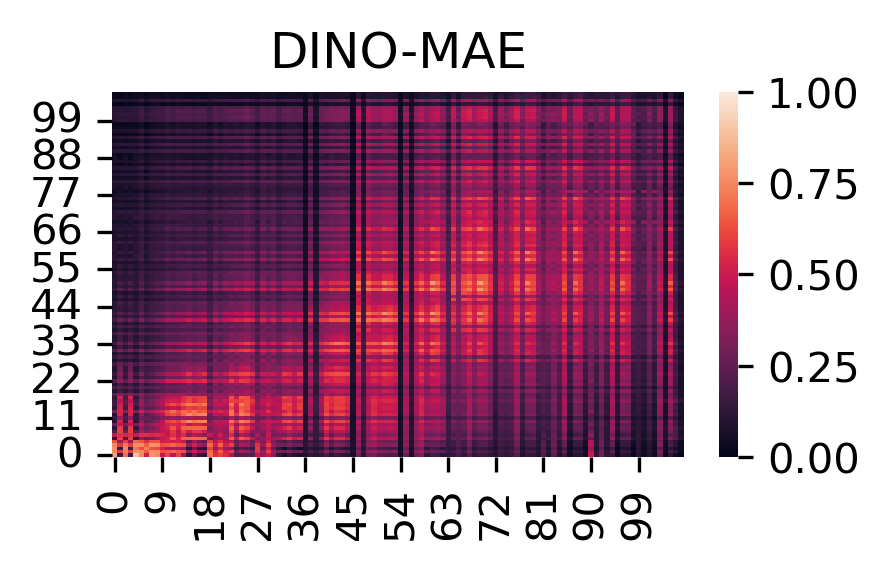

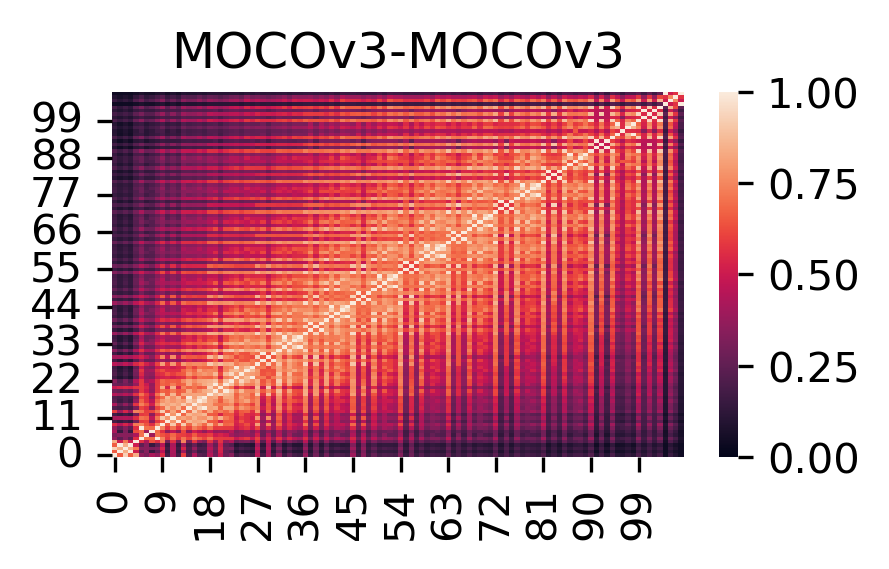

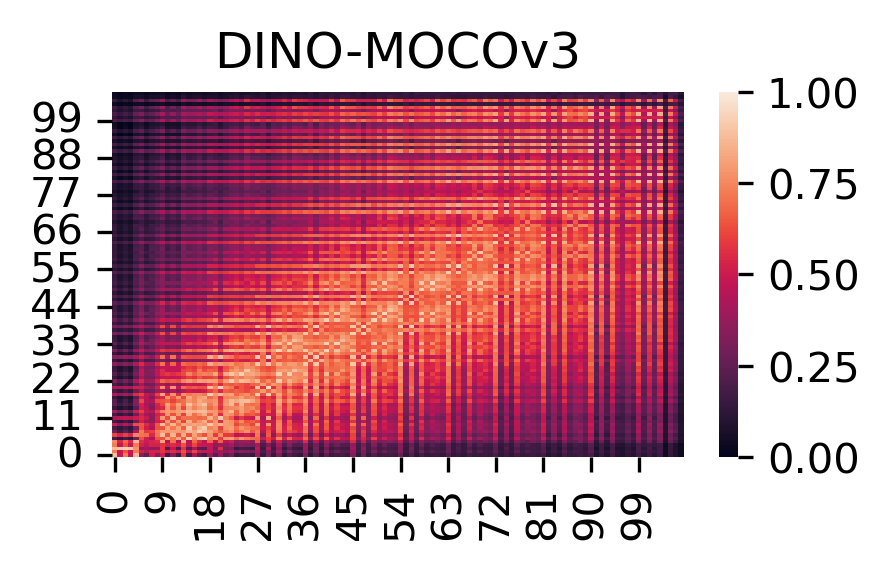

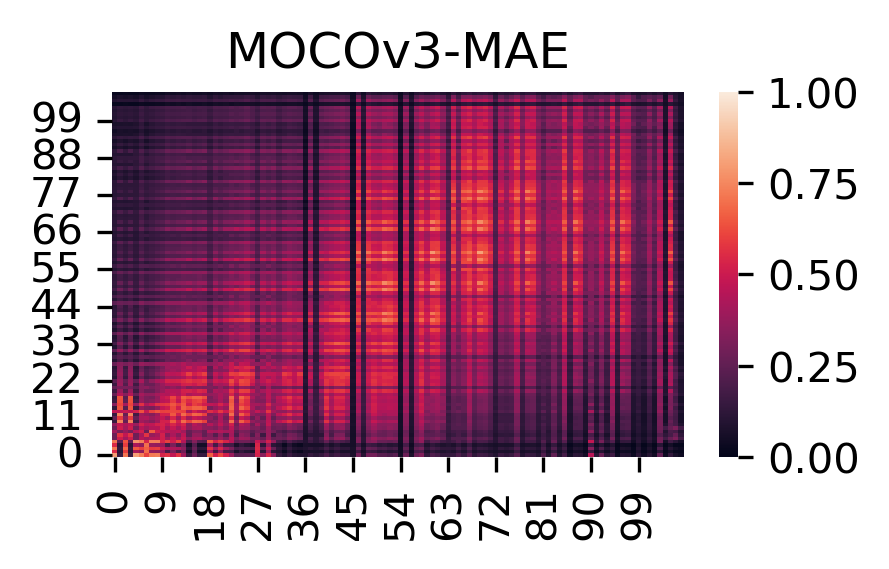

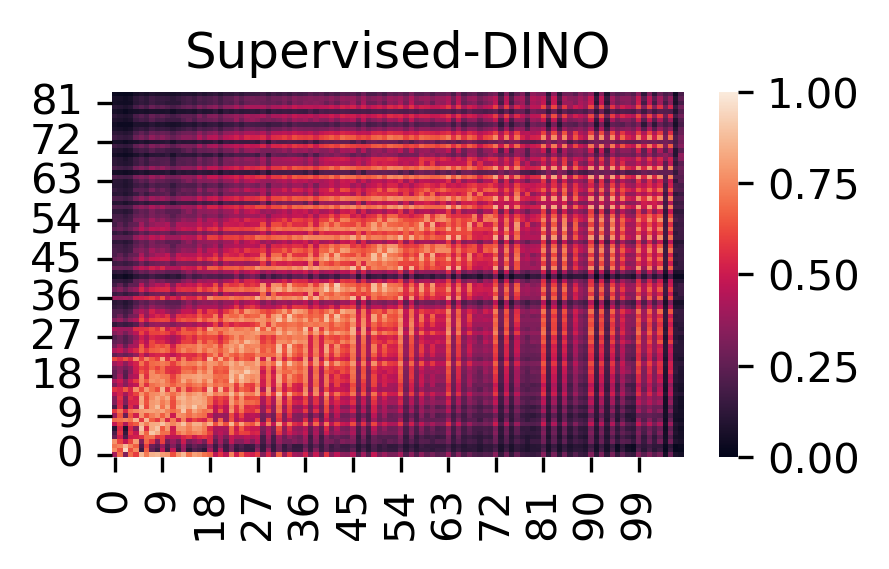

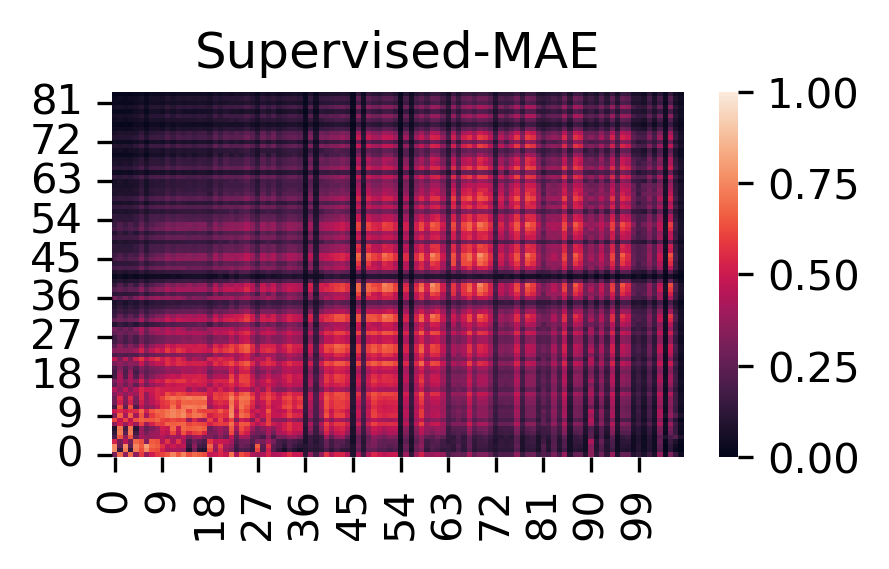

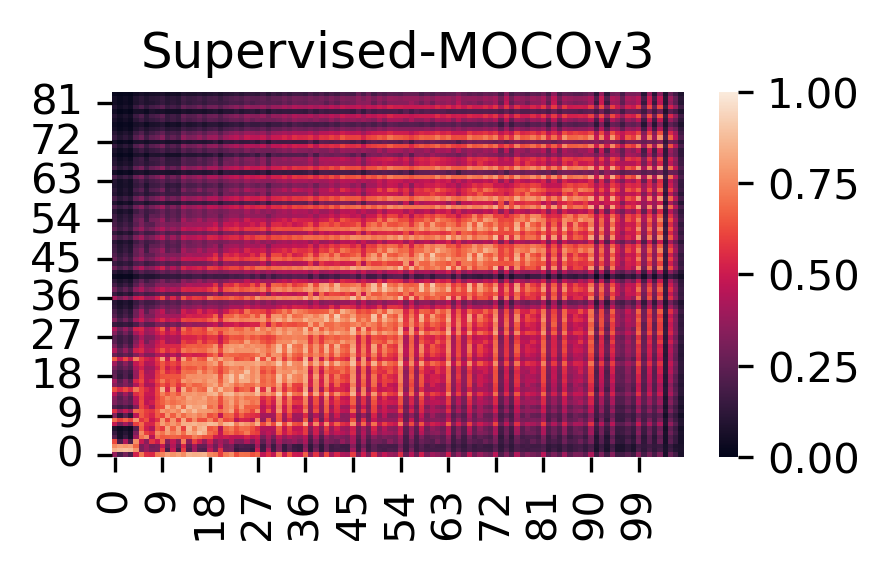

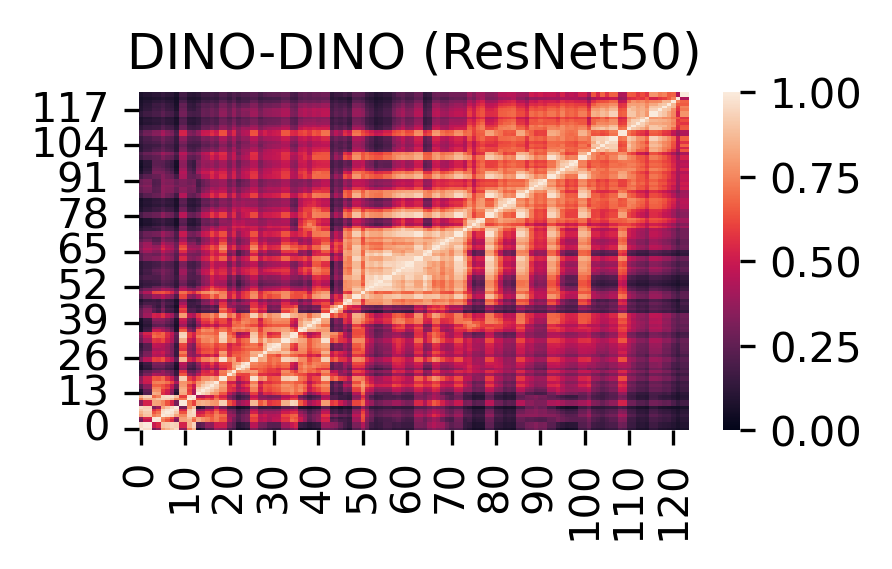

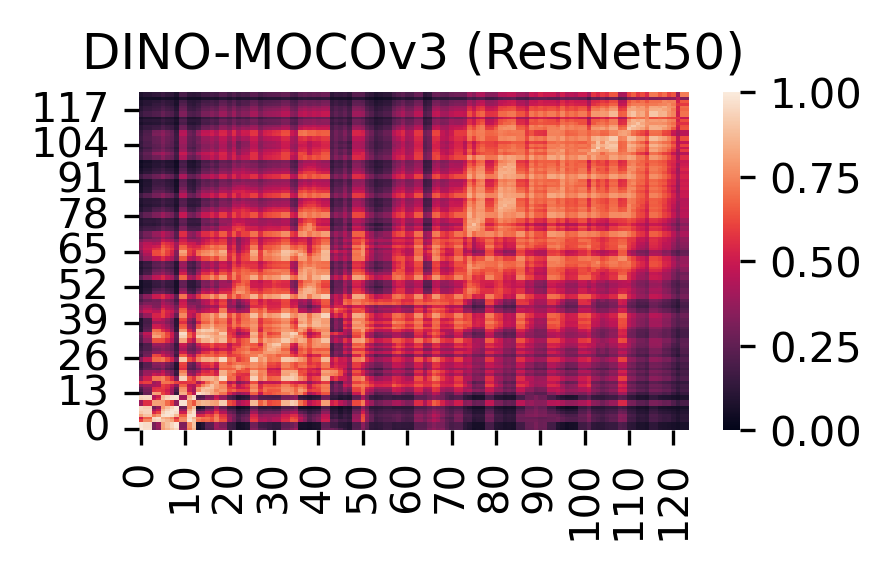

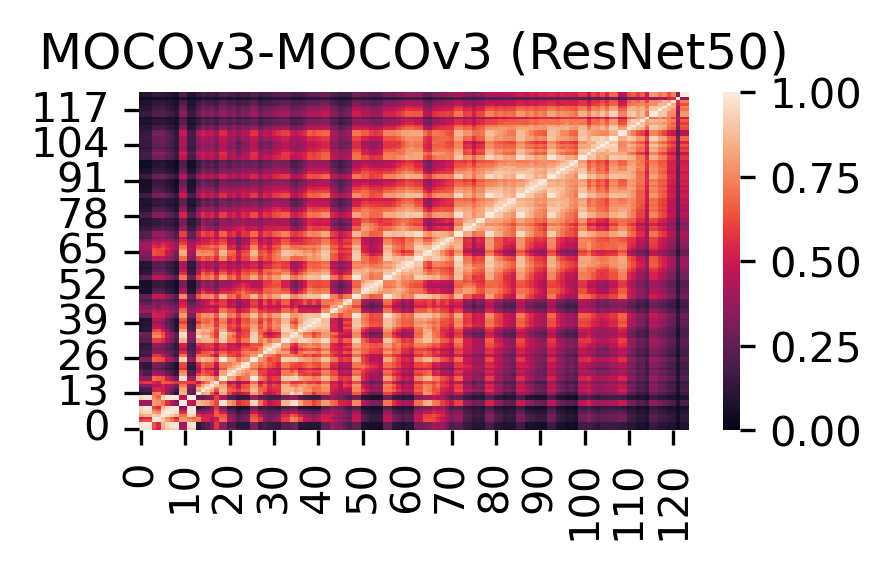

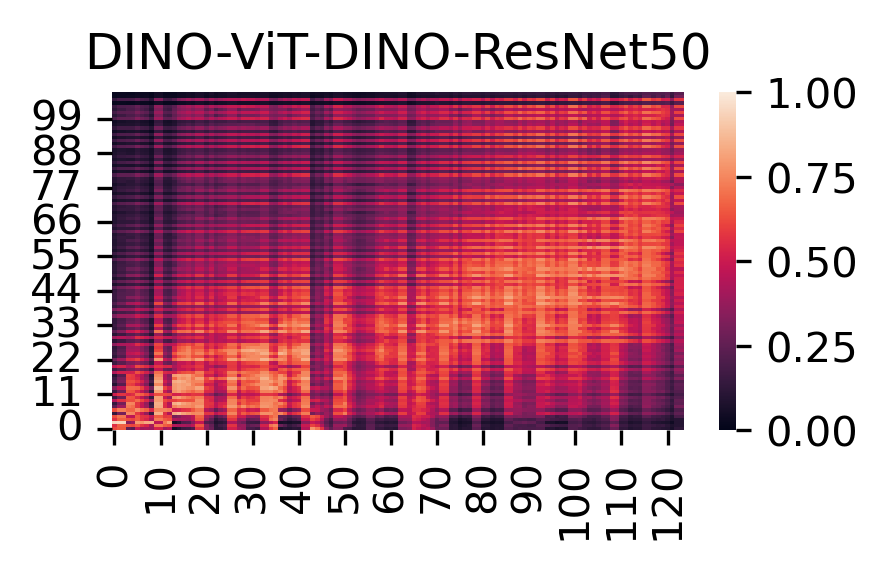

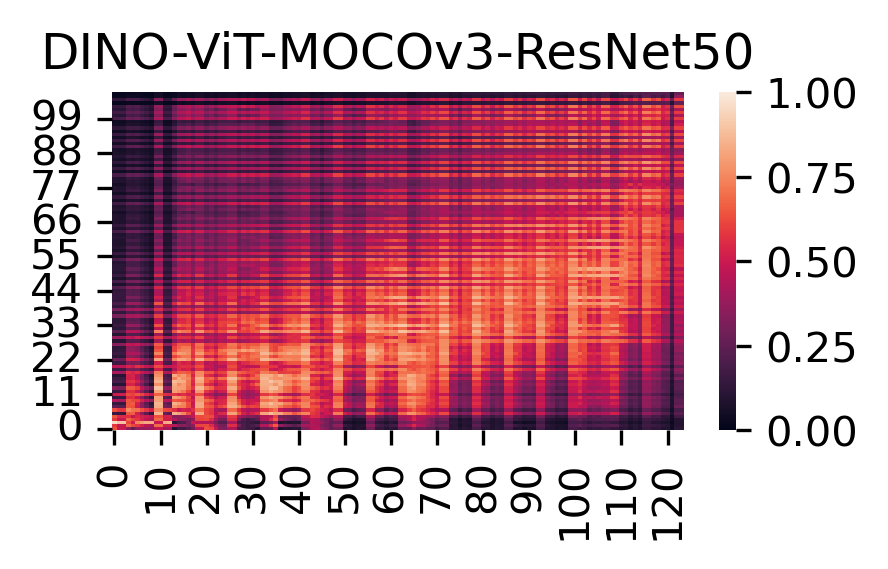

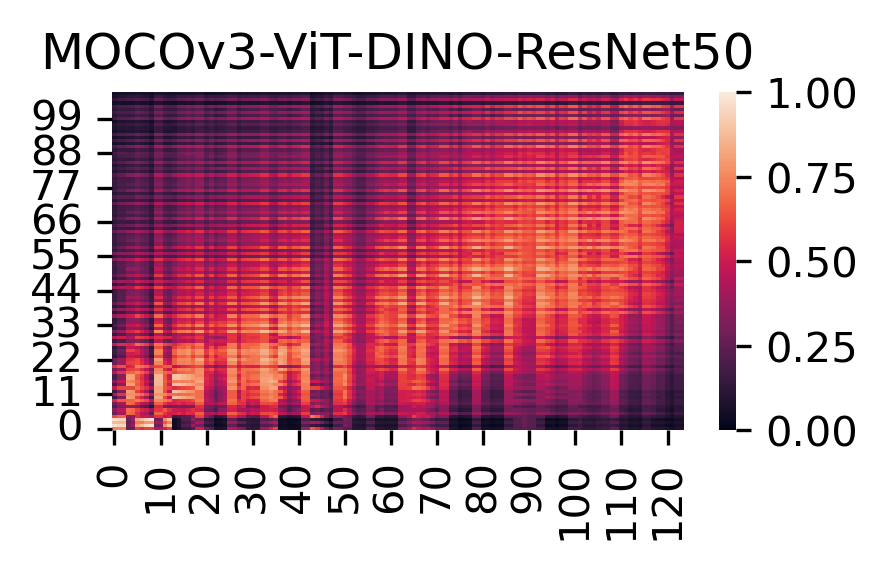

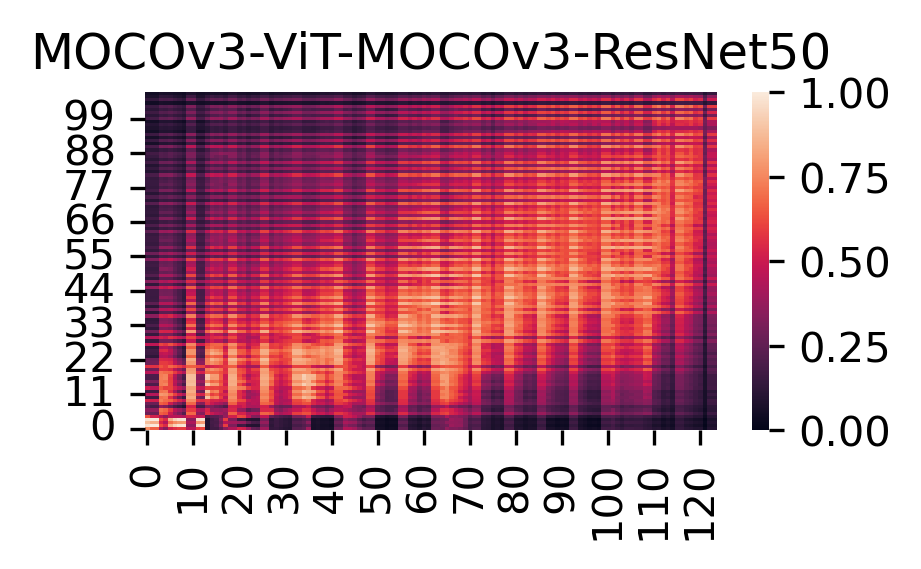

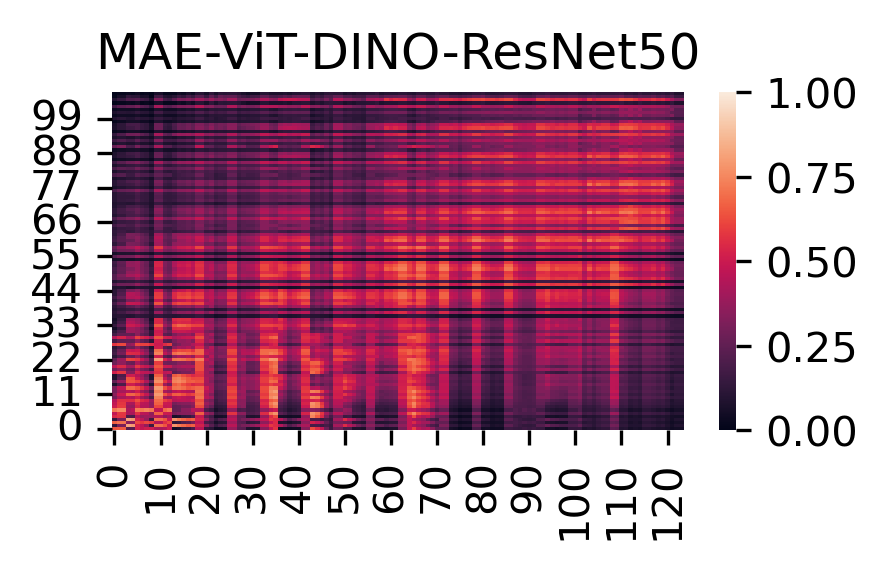

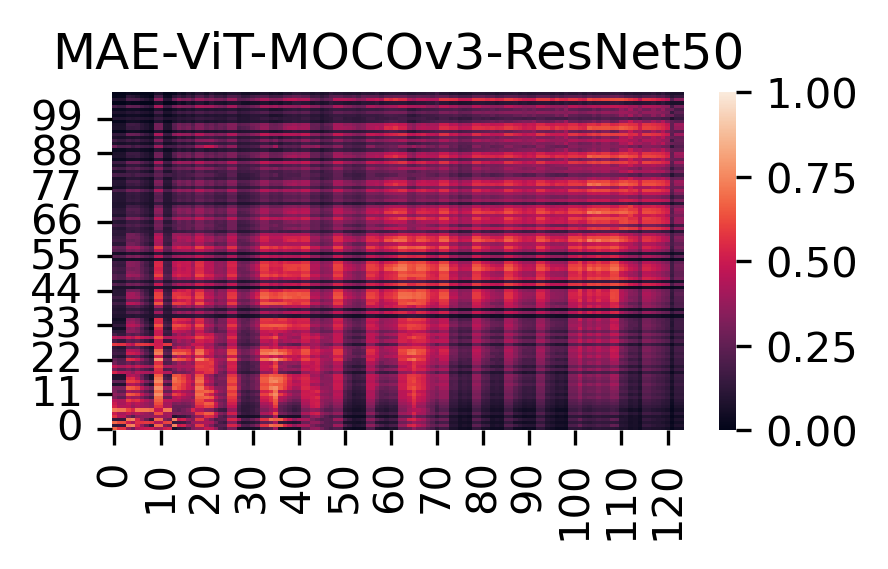

In [8]:
fig_dir = '../figures/CKA/'

fig = figure(figsize=(3, 2), dpi=300)

#sim_mat = get_simmat_from_metrics(metrics_tt)
ax = sns.heatmap(sim_mat_tt, vmin = 0.0, vmax = 1.0)
ax.invert_yaxis()
plt.title('MAE-MAE')
plt.tight_layout()
plt.show()
fig.savefig(fig_dir+'MAE-MAE.png')

fig = figure(figsize=(3, 2), dpi=300)

#sim_mat = get_simmat_from_metrics(metrics_cc)
ax = sns.heatmap(sim_mat_cc, vmin = 0.0, vmax = 1.0)
ax.invert_yaxis()
plt.title('DINO-DINO')
plt.tight_layout()
plt.show()
fig.savefig(fig_dir+'DINO-DINO.png')

fig = figure(figsize=(3, 2), dpi=300)

#sim_mat = get_simmat_from_metrics(metrics_ct)
ax = sns.heatmap(sim_mat_ct, vmin = 0.0, vmax = 1.0)
ax.invert_yaxis()
plt.title('DINO-MAE')
plt.tight_layout()
plt.show()
fig.savefig(fig_dir+'DINO-MAE.png')

fig = figure(figsize=(3, 2), dpi=300)

ax = sns.heatmap(sim_mat_mvmv, vmin = 0.0, vmax = 1.0)
ax.invert_yaxis()
plt.title('MOCOv3-MOCOv3')
plt.tight_layout()
plt.show()
fig.savefig(fig_dir+'MOCOv3-MOCOv3.png')

fig = figure(figsize=(3, 2), dpi=300)

#sim_mat = get_simmat_from_metrics(metrics_cc)
ax = sns.heatmap(sim_mat_cmv, vmin = 0.0, vmax = 1.0)
ax.invert_yaxis()
plt.title('DINO-MOCOv3')
plt.tight_layout()
plt.show()
fig.savefig(fig_dir+'DINO-MOCOv3.png')

fig = figure(figsize=(3, 2), dpi=300)

#sim_mat = get_simmat_from_metrics(metrics_ct)
ax = sns.heatmap(sim_mat_tmv.T, vmin = 0.0, vmax = 1.0)
ax.invert_yaxis()
plt.title('MOCOv3-MAE')
plt.tight_layout()
plt.show()
fig.savefig(fig_dir+'MOCOv3-MAE.png')

indexes = set(range(0, 96)) - set(range(3, 96,8))
indexes = list(indexes)

fig = figure(figsize=(3, 2), dpi=300)

#sim_mat = get_simmat_from_metrics(metrics_cc)
ax = sns.heatmap(sim_mat_sc[indexes, :], vmin = 0.0, vmax = 1.0)
ax.invert_yaxis()
plt.title('Supervised-DINO')
plt.tight_layout()
plt.show()
fig.savefig(fig_dir+'Supervised-DINO.png')

fig = figure(figsize=(3, 2), dpi=300)

#sim_mat = get_simmat_from_metrics(metrics_cc)
ax = sns.heatmap(sim_mat_st[indexes, :], vmin = 0.0, vmax = 1.0)
ax.invert_yaxis()
plt.title('Supervised-MAE')
plt.tight_layout()
plt.show()
fig.savefig(fig_dir+'Supervised-MAE.png')


fig = figure(figsize=(3, 2), dpi=300)

#sim_mat = get_simmat_from_metrics(metrics_cc)
ax = sns.heatmap(sim_mat_smv[indexes, :], vmin = 0.0, vmax = 1.0)
ax.invert_yaxis()
plt.title('Supervised-MOCOv3')
plt.tight_layout()
plt.show()
fig.savefig(fig_dir+'Supervised-MOCO-v3.png')

fig = figure(figsize=(3, 2), dpi=300)

#sim_mat = get_simmat_from_metrics(metrics_cc)
ax = sns.heatmap(sim_mat_rdrd, vmin = 0.0, vmax = 1.0)
ax.invert_yaxis()
plt.title('DINO-DINO (ResNet50)')
plt.tight_layout()
plt.show()
fig.savefig(fig_dir+'DINO-DINO-ResNet50.png')

fig = figure(figsize=(3, 2), dpi=300)

#sim_mat = get_simmat_from_metrics(metrics_cc)
ax = sns.heatmap(sim_mat_rcrd, vmin = 0.0, vmax = 1.0)
ax.invert_yaxis()
plt.title('DINO-MOCOv3 (ResNet50)')
plt.tight_layout()
plt.show()
fig.savefig(fig_dir+'DINO-MOCOv3-ResNet50.png')

fig = figure(figsize=(3, 2), dpi=300)

#sim_mat = get_simmat_from_metrics(metrics_cc)
ax = sns.heatmap(sim_mat_rcrc, vmin = 0.0, vmax = 1.0)
ax.invert_yaxis()
plt.title('MOCOv3-MOCOv3 (ResNet50)')
plt.tight_layout()
plt.show()
fig.savefig(fig_dir+'MOCOv3-ResNet50.png')

fig = figure(figsize=(3, 2), dpi=300)

#sim_mat = get_simmat_from_metrics(metrics_cc)
ax = sns.heatmap(sim_mat_crd, vmin = 0.0, vmax = 1.0)
ax.invert_yaxis()
plt.title('DINO-ViT-DINO-ResNet50')
plt.tight_layout()
plt.show()
fig.savefig(fig_dir+'DINO-ViT-DINO-ResNet50.png')

fig = figure(figsize=(3, 2), dpi=300)

#sim_mat = get_simmat_from_metrics(metrics_cc)
ax = sns.heatmap(sim_mat_crc, vmin = 0.0, vmax = 1.0)
ax.invert_yaxis()
plt.title('DINO-ViT-MOCOv3-ResNet50')
plt.tight_layout()
plt.show()
fig.savefig(fig_dir+'DINO-ViT-MOCOv3-ResNet50.png')

fig = figure(figsize=(3, 2), dpi=300)

#sim_mat = get_simmat_from_metrics(metrics_cc)
ax = sns.heatmap(sim_mat_mvrd, vmin = 0.0, vmax = 1.0)
ax.invert_yaxis()
plt.title('MOCOv3-ViT-DINO-ResNet50')
plt.tight_layout()
plt.show()
fig.savefig(fig_dir+'MOCOv3-ViT-DINO-ResNet50.png')

fig = figure(figsize=(3, 2), dpi=300)

#sim_mat = get_simmat_from_metrics(metrics_cc)
ax = sns.heatmap(sim_mat_mvrc, vmin = 0.0, vmax = 1.0)
ax.invert_yaxis()
plt.title('MOCOv3-ViT-MOCOv3-ResNet50')
plt.tight_layout()
plt.show()
fig.savefig(fig_dir+'MOCOv3-ViT-MOCOv3-ResNet50.png')

fig = figure(figsize=(3, 2), dpi=300)

#sim_mat = get_simmat_from_metrics(metrics_cc)
ax = sns.heatmap(sim_mat_trd, vmin = 0.0, vmax = 1.0)
ax.invert_yaxis()
plt.title('MAE-ViT-DINO-ResNet50')
plt.tight_layout()
plt.show()
fig.savefig(fig_dir+'MAE-ViT-DINO-ResNet50.png')

fig = figure(figsize=(3, 2), dpi=300)

#sim_mat = get_simmat_from_metrics(metrics_cc)
ax = sns.heatmap(sim_mat_trc, vmin = 0.0, vmax = 1.0)
ax.invert_yaxis()
plt.title('MAE-ViT-MOCOv3-ResNet50')
plt.tight_layout()
plt.show()
fig.savefig(fig_dir+'MAE-ViT-MOCOv3-ResNet50.png')


## Similiarity by layer types

### Normalization Layers

In [9]:
indexes = list(range(0, 108, 9)) + list(range(4, 108 ,9))
indexes.sort()
print(indexes)

[0, 4, 9, 13, 18, 22, 27, 31, 36, 40, 45, 49, 54, 58, 63, 67, 72, 76, 81, 85, 90, 94, 99, 103]


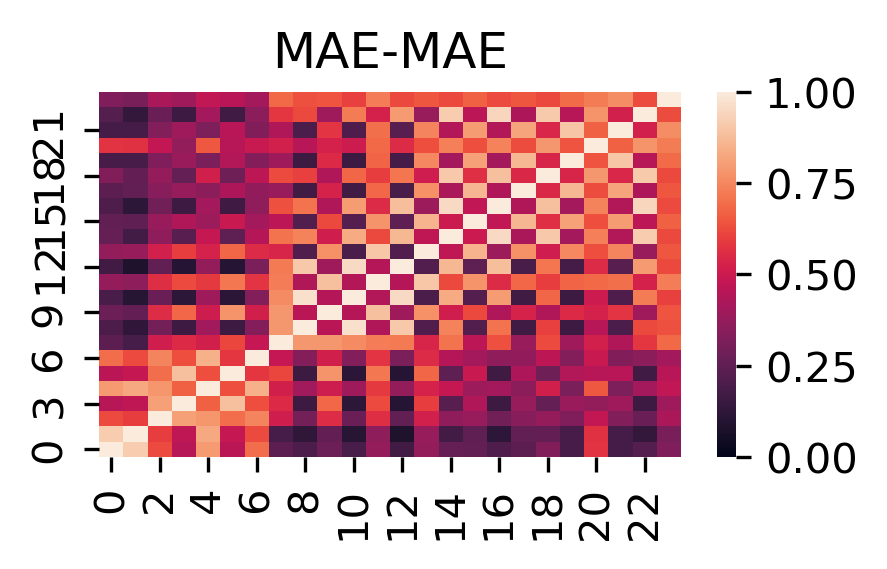

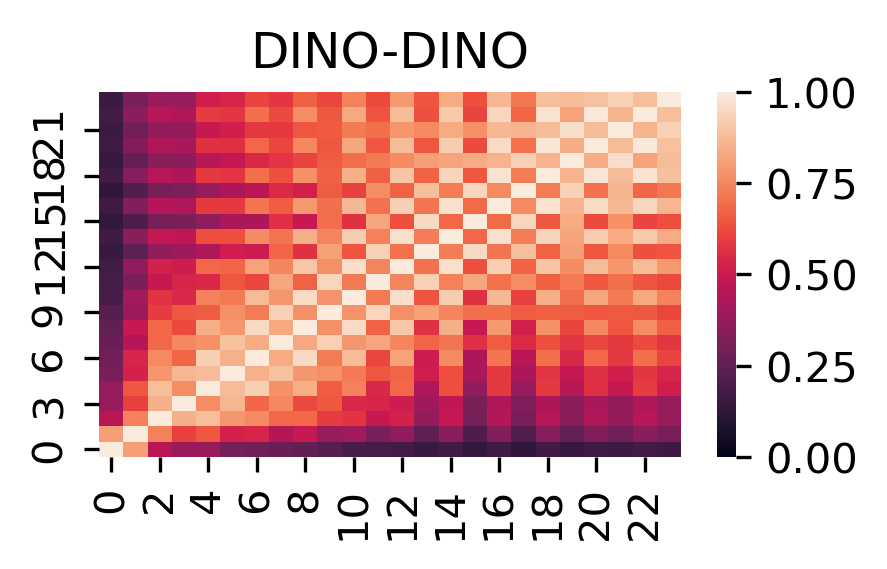

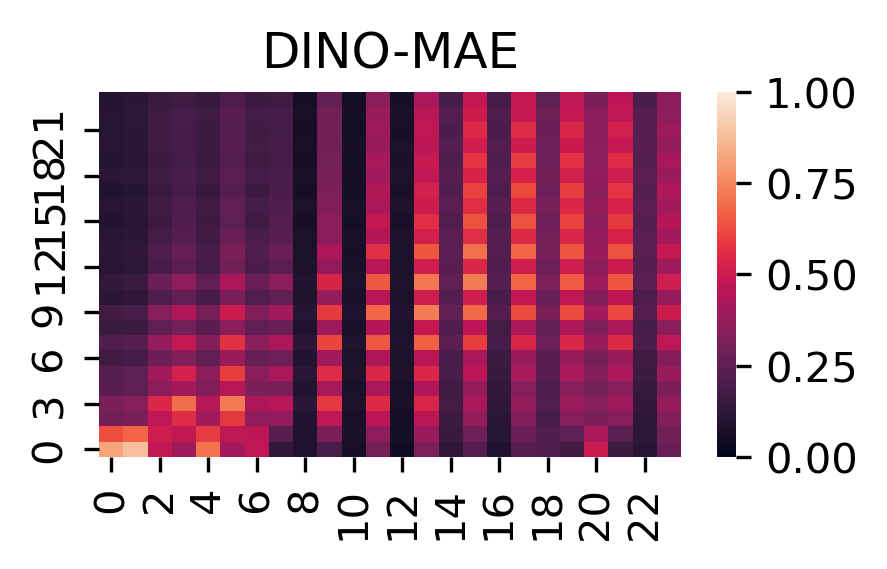

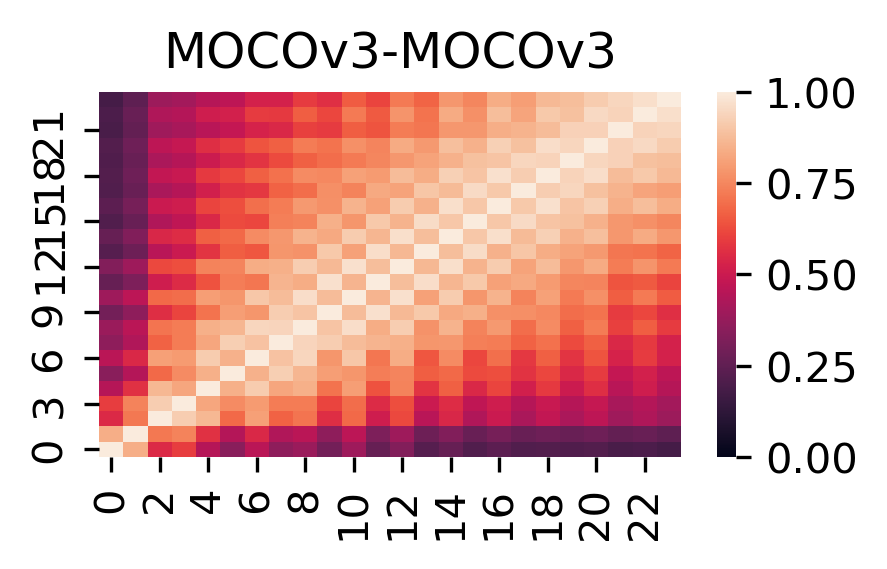

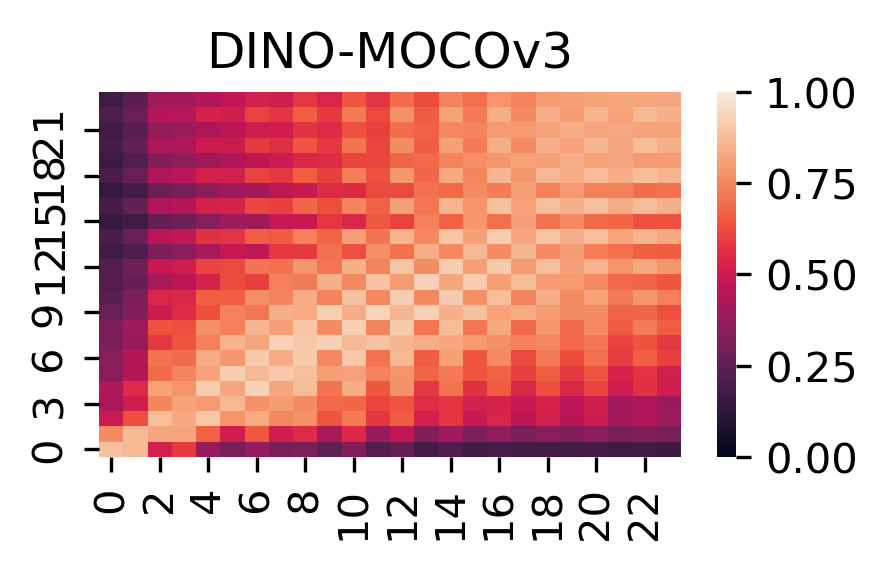

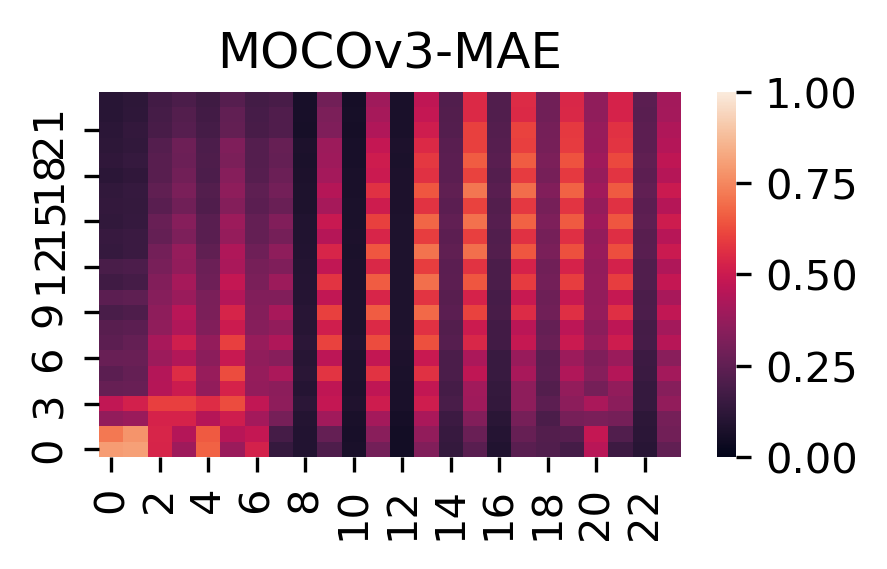

In [10]:
fig_dir = '../figures/CKA/normalization/'


fig = figure(figsize=(3, 2), dpi=300)

#sim_mat = get_simmat_from_metrics(metrics_tt)
ax = sns.heatmap(sim_mat_tt[indexes, :][:, indexes], vmin = 0.0, vmax = 1.0)
ax.invert_yaxis()
plt.title('MAE-MAE')
plt.tight_layout()
plt.show()
fig.savefig(fig_dir+'MAE-MAE.png')

fig = figure(figsize=(3, 2), dpi=300)

#sim_mat = get_simmat_from_metrics(metrics_cc)
ax = sns.heatmap(sim_mat_cc[indexes, :][:, indexes], vmin = 0.0, vmax = 1.0)
ax.invert_yaxis()
plt.title('DINO-DINO')
plt.tight_layout()
plt.show()
fig.savefig(fig_dir+'DINO-DINO.png')

fig = figure(figsize=(3, 2), dpi=300)

#sim_mat = get_simmat_from_metrics(metrics_ct)
ax = sns.heatmap(sim_mat_ct[indexes, :][:, indexes], vmin = 0.0, vmax = 1.0)
ax.invert_yaxis()
plt.title('DINO-MAE')
plt.tight_layout()
plt.show()
fig.savefig(fig_dir+'DINO-MAE.png')

fig = figure(figsize=(3, 2), dpi=300)

ax = sns.heatmap(sim_mat_mvmv[indexes, :][:, indexes], vmin = 0.0, vmax = 1.0)
ax.invert_yaxis()
plt.title('MOCOv3-MOCOv3')
plt.tight_layout()
plt.show()
fig.savefig(fig_dir+'MOCOv3-MOCOv3.png')

fig = figure(figsize=(3, 2), dpi=300)

#sim_mat = get_simmat_from_metrics(metrics_cc)
ax = sns.heatmap(sim_mat_cmv[indexes, :][:, indexes], vmin = 0.0, vmax = 1.0)
ax.invert_yaxis()
plt.title('DINO-MOCOv3')
plt.tight_layout()
plt.show()
fig.savefig(fig_dir+'DINO-MOCOv3.png')

fig = figure(figsize=(3, 2), dpi=300)

#sim_mat = get_simmat_from_metrics(metrics_ct)
ax = sns.heatmap(sim_mat_tmv.T[indexes, :][:, indexes], vmin = 0.0, vmax = 1.0)
ax.invert_yaxis()
plt.title('MOCOv3-MAE')
plt.tight_layout()
plt.show()
fig.savefig(fig_dir+'MOCOv3-MAE.png')


### Attention Layers

In [ ]:
indexes = list(range(1, 108, 9)) + list(range(2, 108 ,9)) + list(range(3, 108 ,9))
indexes.sort()
print(indexes)

In [ ]:
fig_dir = '../figures/CKA/attention/'


fig = figure(figsize=(3, 2), dpi=300)

#sim_mat = get_simmat_from_metrics(metrics_tt)
ax = sns.heatmap(sim_mat_tt[indexes, :][:, indexes], vmin = 0.0, vmax = 1.0)
ax.invert_yaxis()
plt.title('MAE-MAE')
plt.tight_layout()
plt.show()
fig.savefig(fig_dir+'MAE-MAE.png')

fig = figure(figsize=(3, 2), dpi=300)

#sim_mat = get_simmat_from_metrics(metrics_cc)
ax = sns.heatmap(sim_mat_cc[indexes, :][:, indexes], vmin = 0.0, vmax = 1.0)
ax.invert_yaxis()
plt.title('DINO-DINO')
plt.tight_layout()
plt.show()
fig.savefig(fig_dir+'DINO-DINO.png')

fig = figure(figsize=(3, 2), dpi=300)

#sim_mat = get_simmat_from_metrics(metrics_ct)
ax = sns.heatmap(sim_mat_ct[indexes, :][:, indexes], vmin = 0.0, vmax = 1.0)
ax.invert_yaxis()
plt.title('DINO-MAE')
plt.tight_layout()
plt.show()
fig.savefig(fig_dir+'DINO-MAE.png')

fig = figure(figsize=(3, 2), dpi=300)

ax = sns.heatmap(sim_mat_mvmv[indexes, :][:, indexes], vmin = 0.0, vmax = 1.0)
ax.invert_yaxis()
plt.title('MOCOv3-MOCOv3')
plt.tight_layout()
plt.show()
fig.savefig(fig_dir+'MOCOv3-MOCOv3.png')

fig = figure(figsize=(3, 2), dpi=300)

#sim_mat = get_simmat_from_metrics(metrics_cc)
ax = sns.heatmap(sim_mat_cmv[indexes, :][:, indexes], vmin = 0.0, vmax = 1.0)
ax.invert_yaxis()
plt.title('DINO-MOCOv3')
plt.tight_layout()
plt.show()
fig.savefig(fig_dir+'DINO-MOCOv3.png')

fig = figure(figsize=(3, 2), dpi=300)

#sim_mat = get_simmat_from_metrics(metrics_ct)
ax = sns.heatmap(sim_mat_tmv.T[indexes, :][:, indexes], vmin = 0.0, vmax = 1.0)
ax.invert_yaxis()
plt.title('MOCOv3-MAE')
plt.tight_layout()
plt.show()
fig.savefig(fig_dir+'MOCOv3-MAE.png')

### MLP Layers

In [ ]:
indexes = list(range(5, 108, 9)) + list(range(6, 108 ,9)) + list(range(7, 108 ,9)) + list(range(8, 108 ,9))
indexes.sort()
print(indexes)

In [ ]:
fig_dir = '../figures/CKA/mlp_layers/'


fig = figure(figsize=(3, 2), dpi=300)

#sim_mat = get_simmat_from_metrics(metrics_tt)
ax = sns.heatmap(sim_mat_tt[indexes, :][:, indexes], vmin = 0.0, vmax = 1.0)
ax.invert_yaxis()
plt.title('MAE-MAE')
plt.tight_layout()
plt.show()
fig.savefig(fig_dir+'MAE-MAE.png')

fig = figure(figsize=(3, 2), dpi=300)

#sim_mat = get_simmat_from_metrics(metrics_cc)
ax = sns.heatmap(sim_mat_cc[indexes, :][:, indexes], vmin = 0.0, vmax = 1.0)
ax.invert_yaxis()
plt.title('DINO-DINO')
plt.tight_layout()
plt.show()
fig.savefig(fig_dir+'DINO-DINO.png')

fig = figure(figsize=(3, 2), dpi=300)

#sim_mat = get_simmat_from_metrics(metrics_ct)
ax = sns.heatmap(sim_mat_ct[indexes, :][:, indexes], vmin = 0.0, vmax = 1.0)
ax.invert_yaxis()
plt.title('DINO-MAE')
plt.tight_layout()
plt.show()
fig.savefig(fig_dir+'DINO-MAE.png')

fig = figure(figsize=(3, 2), dpi=300)

ax = sns.heatmap(sim_mat_mvmv[indexes, :][:, indexes], vmin = 0.0, vmax = 1.0)
ax.invert_yaxis()
plt.title('MOCOv3-MOCOv3')
plt.tight_layout()
plt.show()
fig.savefig(fig_dir+'MOCOv3-MOCOv3.png')

fig = figure(figsize=(3, 2), dpi=300)

#sim_mat = get_simmat_from_metrics(metrics_cc)
ax = sns.heatmap(sim_mat_cmv[indexes, :][:, indexes], vmin = 0.0, vmax = 1.0)
ax.invert_yaxis()
plt.title('DINO-MOCOv3')
plt.tight_layout()
plt.show()
fig.savefig(fig_dir+'DINO-MOCOv3.png')

fig = figure(figsize=(3, 2), dpi=300)

#sim_mat = get_simmat_from_metrics(metrics_ct)
ax = sns.heatmap(sim_mat_tmv.T[indexes, :][:, indexes], vmin = 0.0, vmax = 1.0)
ax.invert_yaxis()
plt.title('MOCOv3-MAE')
plt.tight_layout()
plt.show()
fig.savefig(fig_dir+'MOCOv3-MAE.png')